<a href="https://colab.research.google.com/github/finerbrighterlighter/myanmar_covid19/blob/master/exponential_growth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Libraries

In [1]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from google.colab import files
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#Data

Since the Government fails to provide a complete and open dataset for disease status in the country, several young doctors in Myanmar volunteered on their own to monitor announcements. Current data applied is collected by Dr. Nyein Chan Ko Ko.

In [2]:
data = "https://raw.githubusercontent.com/finerbrighterlighter/myanmar_covid19/master/mohs_announcement.csv"
df = pd.read_csv(data,header= 0)
df.insert(loc=0, column="case_id", value=np.arange(1,len(df)+1))
df["case_id"] = "case_" + df["case_id"].astype(str)
df

,case_id,age,sex,travel,region,first_date,qua_date,ann_date,exp_date
0,case_1,36,Male,United States,Chin,2020-03-13,2020-03-21,2020-03-23,NaN
1,case_2,26,Male,United Kingdom,Yangon,2020-03-22,2020-03-23,2020-03-23,NaN
2,case_3,26,Male,United Kingdom,Yangon,2020-03-21,2020-03-23,2020-03-25,NaN
3,case_4,33,Male,United States of America,Yangon,2020-03-19,2020-03-25,2020-03-27,NaN
4,case_5,69,Male,Australia -> Singapore,Yangon,2020-03-14,2020-03-25,2020-03-27,2020-03-31
5,case_6,29,Male,United Kingdom,Yangon,2020-03-21,2020-03-26,2020-03-28,NaN
6,case_7,58,Female,Switzerland,Nay Pyi Taw,2020-03-18,2020-03-26,2020-03-28,NaN
7,case_8,60,Female,NaN,Yangon,2020-03-25,2020-03-26,2020-03-28,NaN
8,case_9,44,Male,Thailand,Yangon,2020-03-23,2020-03-26,2020-03-29,NaN
9,case_10,45,Male,NaN,Yangon,2020-03-28,2020-03-28,2020-03-29,NaN


# Timeline

In [3]:
df["first_date"] = pd.to_datetime(df["first_date"])
df["qua_date"] = pd.to_datetime(df["qua_date"])
df["ann_date"] = pd.to_datetime(df["ann_date"])
df["ann_date"] = pd.to_datetime(df["ann_date"])
df["exp_date"] = pd.to_datetime(df["exp_date"])
df["until_qua"] = (df["qua_date"]-df["first_date"]).dt.days
df["until_ann"] = (df["ann_date"]-df["qua_date"]).dt.days
df

,case_id,age,sex,travel,region,first_date,qua_date,ann_date,exp_date,until_qua,until_ann
0,case_1,36,Male,United States,Chin,2020-03-13,2020-03-21,2020-03-23,NaT,8,2
1,case_2,26,Male,United Kingdom,Yangon,2020-03-22,2020-03-23,2020-03-23,NaT,1,0
2,case_3,26,Male,United Kingdom,Yangon,2020-03-21,2020-03-23,2020-03-25,NaT,2,2
3,case_4,33,Male,United States of America,Yangon,2020-03-19,2020-03-25,2020-03-27,NaT,6,2
4,case_5,69,Male,Australia -> Singapore,Yangon,2020-03-14,2020-03-25,2020-03-27,2020-03-31,11,2
5,case_6,29,Male,United Kingdom,Yangon,2020-03-21,2020-03-26,2020-03-28,NaT,5,2
6,case_7,58,Female,Switzerland,Nay Pyi Taw,2020-03-18,2020-03-26,2020-03-28,NaT,8,2
7,case_8,60,Female,NaN,Yangon,2020-03-25,2020-03-26,2020-03-28,NaT,1,2
8,case_9,44,Male,Thailand,Yangon,2020-03-23,2020-03-26,2020-03-29,NaT,3,3
9,case_10,45,Male,NaN,Yangon,2020-03-28,2020-03-28,2020-03-29,NaT,0,1


In [0]:
df["until_first"] = (df["first_date"]-df["first_date"].min()).dt.days
df["until_exp"] = np.where(df["exp_date"].notna(), (df["exp_date"]-df["ann_date"]).dt.days, 0)
df["until_dsc"] = np.where(df["exp_date"].isna(), (pd.to_datetime("now")-df["ann_date"]).dt.days, 0)

- travel -> travel history
- region -> states and admininstrative regions of Myanmar where the case is quarantined
- first_date -> entry into the country, or first symptom for no travel history
- qua_date -> first date of quarantine
- ann_date -> date of announcement by MOHS as positive

##Time taking for Action

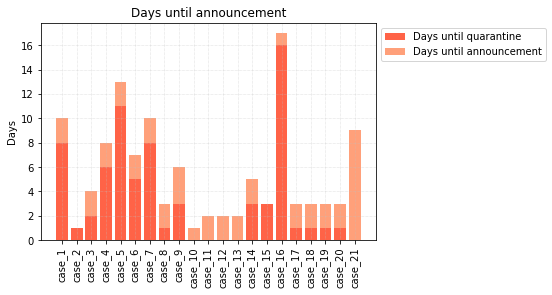

In [5]:
fig, ax = plt.subplots()
ax.grid(linestyle=':', linewidth='0.5', color='silver')

index = np.arange(len(df["case_id"]))

p1 = plt.bar(index, df["until_qua"], color = "tomato")
p2 = plt.bar(index, df["until_ann"], bottom=df["until_qua"], color = "lightsalmon")

plt.ylabel("Days", fontsize=10)
plt.title("Days until announcement")
plt.xticks(index,df["case_id"], fontsize=10, rotation=90)
plt.legend((p1[0], p2[0]), ("Days until quarantine", "Days until announcement"),loc="upper left", bbox_to_anchor=(1, 1))

days = str(df["ann_date"][df.index[-1]])+"_time_for_action.svg"
plt.savefig(days, bbox_inches = "tight")
plt.show()
files.download(days)

##Timeline

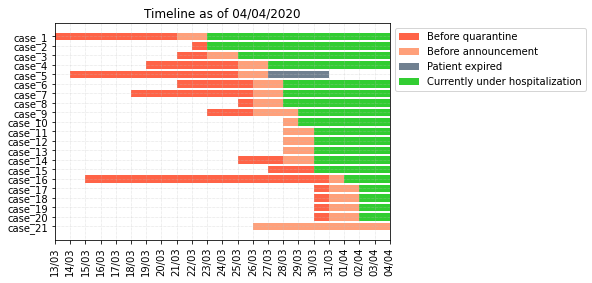

In [6]:
fig, ax = plt.subplots()
ax.grid(linestyle=':', linewidth='0.5', color='silver')

yindex = np.arange(len(df["case_id"]))
xindex = np.arange(len(pd.date_range(start=df.first_date.min(), end=pd.to_datetime("now"))))

plt.yticks(yindex,df["case_id"], fontsize=10)
plt.xticks(xindex,pd.date_range(start=df.first_date.min(), end=pd.to_datetime("now")).strftime('%d/%m'), fontsize=10, rotation=90)
plt.gca().invert_yaxis()

until_qua = plt.barh(yindex, df["until_qua"], left= df["until_first"], color = "tomato")
until_ann = plt.barh(yindex, df["until_ann"], left= df["until_qua"]+df["until_first"], color = "lightsalmon")
until_exp = plt.barh(yindex, df["until_exp"], left= df["until_ann"]+df["until_qua"]+df["until_first"], color = "slategray")
until_dsc = plt.barh(yindex, df["until_dsc"], left= df["until_exp"]+df["until_ann"]+df["until_qua"]+df["until_first"], color = "limegreen")

plt.title("Timeline as of "+str(df.ann_date.max().strftime("%d/%m/%Y")))
plt.legend((until_qua[0], until_ann[0],until_exp[0],until_dsc[0]), ("Before quarantine", "Before announcement","Patient expired","Currently under hospitalization"),loc='upper left', bbox_to_anchor=(1, 1))

timeline = str(df["ann_date"][df.index[-1]])+"_timeline.svg"
plt.savefig(timeline, bbox_inches = "tight")
plt.show()
files.download(timeline)

# Basic Line Chart for overseas inflow vs local spread

In [0]:
spread_df = df[["ann_date","travel"]].copy()
spread_df.columns = ["date", "travel"]

spread_df["overseas_inflow"] = np.where(spread_df["travel"].isna(), 0, 1)
spread_df["local_spread"] = np.where(spread_df["travel"].notna(), 0, 1)

spread_df.drop("travel", axis=1 , inplace=True)
spread_df=spread_df.groupby(["date"]).sum().reset_index()
spread_df["date"] = pd.to_datetime(spread_df["date"])

In [8]:
spread_trend_df = pd.DataFrame(columns=["ndays","date"])
spread_trend_df["ndays"] = np.arange(len(pd.date_range(start=spread_df.date.min()-pd.Timedelta(days=5), end=spread_df.date.max())))
spread_trend_df.loc[0,"date"]=spread_df.date.min()-pd.Timedelta(days=5)
for i in range(1,len(spread_trend_df)):
    spread_trend_df.loc[i,"date"] = spread_trend_df.loc[i-1,"date"] + pd.Timedelta(days=1)
    i=i+1
spread_trend_df["date"] = pd.to_datetime(spread_trend_df["date"])

spread_trend_df=spread_trend_df.merge(spread_df,indicator=False,how='left')
spread_trend_df["overseas_inflow"].fillna(0, inplace=True)
spread_trend_df["local_spread"].fillna(0, inplace=True)
spread_trend_df["overseas_inflow"]=spread_trend_df["overseas_inflow"].astype(int)
spread_trend_df["local_spread"]=spread_trend_df["local_spread"].astype(int)
spread_trend_df["tot_overseas_inflow"]=spread_trend_df["overseas_inflow"].cumsum()
spread_trend_df["tot_local_spread"]=spread_trend_df["local_spread"].cumsum()
spread_trend_df

,ndays,date,overseas_inflow,local_spread,tot_overseas_inflow,tot_local_spread
0,0,2020-03-18,0,0,0,0
1,1,2020-03-19,0,0,0,0
2,2,2020-03-20,0,0,0,0
3,3,2020-03-21,0,0,0,0
4,4,2020-03-22,0,0,0,0
5,5,2020-03-23,2,0,2,0
6,6,2020-03-24,0,0,2,0
7,7,2020-03-25,1,0,3,0
8,8,2020-03-26,0,0,3,0
9,9,2020-03-27,2,0,5,0


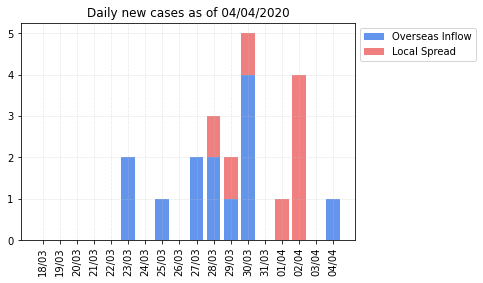

In [9]:
fig, ax = plt.subplots()
ax.grid(linestyle=':', linewidth='0.5', color='silver')

xindex = np.arange(len(pd.date_range(start=spread_trend_df.date.min(), end=spread_trend_df.date.max())))

plt.xticks(xindex,pd.date_range(start=spread_trend_df.date.min(), end=spread_trend_df.date.max()).strftime('%d/%m'), fontsize=10, rotation=90)
plt.gca().yaxis.set_major_locator(mticker.MultipleLocator(1))

oi_case = plt.bar(xindex, spread_trend_df["overseas_inflow"], color = "cornflowerblue")
ls_case = plt.bar(xindex, spread_trend_df["local_spread"], bottom=spread_trend_df["overseas_inflow"], color = "lightcoral")

plt.title("Daily new cases as of "+str(spread_trend_df.date.max().strftime("%d/%m/%Y")))
plt.legend((oi_case[0],ls_case[0]), ("Overseas Inflow", "Local Spread"),loc='upper left', bbox_to_anchor=(1, 1))

new_cases = str(df["ann_date"][df.index[-1]])+"_new_cases.svg"
plt.savefig(new_cases, bbox_inches = "tight")
plt.show()
files.download(new_cases)

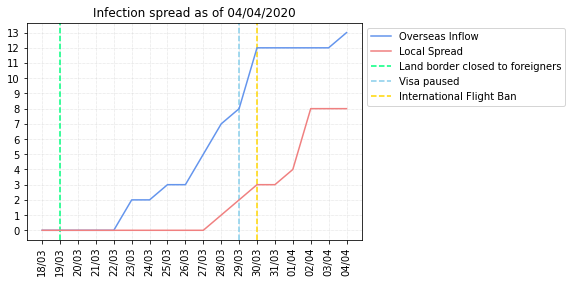

In [10]:
fig, ax = plt.subplots()
ax.grid(linestyle=':', linewidth='0.5', color='silver')

xindex = np.arange(len(pd.date_range(start=spread_trend_df.date.min(), end=spread_trend_df.date.max())))

plt.xticks(xindex,pd.date_range(start=spread_trend_df.date.min(), end=spread_trend_df.date.max()).strftime('%d/%m'), fontsize=10, rotation=90)
plt.gca().yaxis.set_major_locator(mticker.MultipleLocator(1))

land_close_fore = plt.axvline(x=1, color="springgreen", linestyle="--")
visa_close = plt.axvline(x=11, color="skyblue", linestyle="--")
air_close = plt.axvline(x=12, color="gold", linestyle="--")
overseas_inflow = plt.plot(xindex, spread_trend_df["tot_overseas_inflow"], color="cornflowerblue")
local_spread = plt.plot(xindex, spread_trend_df["tot_local_spread"], color="lightcoral")

plt.title("Infection spread as of "+str(spread_trend_df.date.max().strftime("%d/%m/%Y")))
plt.legend((overseas_inflow[0],local_spread[0],land_close_fore,visa_close,air_close), ("Overseas Inflow", "Local Spread","Land border closed to foreigners","Visa paused","International Flight Ban"),loc='upper left', bbox_to_anchor=(1, 1))

spread = str(df["ann_date"][df.index[-1]])+"_spread.svg"
plt.savefig(spread, bbox_inches = "tight")
plt.show()
files.download(spread)

# Exponential Growth

In [11]:
sum_df = df[["ann_date","case_id"]].copy()
sum_df.columns = ["Date", "id"]
sum_df=sum_df.groupby(["Date"]).size().to_frame("Case").reset_index()
sum_df["Date"] = pd.to_datetime(sum_df["Date"])
sum_df

,Date,Case
0,2020-03-23,2
1,2020-03-25,1
2,2020-03-27,2
3,2020-03-28,3
4,2020-03-29,2
5,2020-03-30,5
6,2020-04-01,1
7,2020-04-02,4
8,2020-04-04,1


In [12]:
confirmed_df = pd.DataFrame(columns=["ndays","Date"])
confirmed_df["ndays"] = np.arange(len(pd.date_range(start=sum_df.Date.min(), end=sum_df.Date.max())))
confirmed_df.loc[0,"Date"]=sum_df.Date.min()
for i in range(1,len(confirmed_df)):
    confirmed_df.loc[i,"Date"] = confirmed_df.loc[i-1,"Date"] + pd.Timedelta(days=1)
    i=i+1
confirmed_df["Date"] = pd.to_datetime(confirmed_df["Date"])
confirmed_df=confirmed_df.merge(sum_df,indicator=False,how='left')
confirmed_df["Case"].fillna(0, inplace=True)
confirmed_df["Case"]=confirmed_df["Case"].astype(int)
confirmed_df["Case"] = confirmed_df["Case"].cumsum()

# Natural Log of Real Cases
confirmed_df["logCase"] = np.log(confirmed_df.Case).astype(float)
confirmed_df

,ndays,Date,Case,logCase
0,0,2020-03-23,2,0.693147
1,1,2020-03-24,2,0.693147
2,2,2020-03-25,3,1.098612
3,3,2020-03-26,3,1.098612
4,4,2020-03-27,5,1.609438
5,5,2020-03-28,8,2.079442
6,6,2020-03-29,10,2.302585
7,7,2020-03-30,15,2.708050
8,8,2020-03-31,15,2.708050
9,9,2020-04-01,16,2.772589


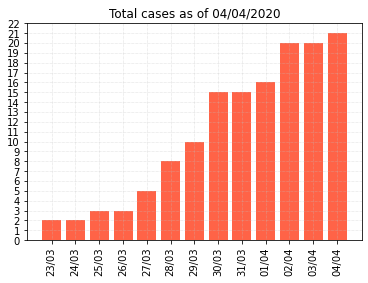

In [13]:
fig, ax = plt.subplots()
ax.grid(linestyle=':', linewidth='0.5', color='silver')

xindex = np.arange(len(pd.date_range(start=confirmed_df.Date.min(), end=confirmed_df.Date.max())))

plt.xticks(xindex,pd.date_range(start=confirmed_df.Date.min(), end=confirmed_df.Date.max()).strftime('%d/%m'), fontsize=10, rotation=90)
plt.gca().yaxis.set_major_locator(mticker.MultipleLocator(1))

plt.bar(xindex, confirmed_df["Case"], color = "tomato")

plt.title("Total cases as of "+str(spread_trend_df.date.max().strftime("%d/%m/%Y")))

tot_cases = str(df["ann_date"][df.index[-1]])+"_total_cases.svg"
plt.savefig(tot_cases, bbox_inches = "tight")
plt.show()
files.download(tot_cases)

Natural log makes it better in terms of visualization and long term comparison, make the data look more linear. That is why I will be plotting both real and natural log line graphs.

# Model of choice

True exponential does not exist, but exponential growth is assumed until the inflection point has arrived. Linear Regression is applied.

## Logistic Regression
### Ordinary Least Squared Regression

In [14]:
X = confirmed_df.ndays
X = sm.add_constant(X)
y = confirmed_df.logCase
model = sm.OLS(y, X)
result = model.fit()
result.summary()

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                logCase   R-squared:                       0.934
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                     155.9
Date:                Sat, 04 Apr 2020   Prob (F-statistic):           7.72e-08
Time:                        16:18:31   Log-Likelihood:                0.99264
No. Observations:                  13   AIC:                             2.015
Df Residuals:                      11   BIC:                             3.145
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7080      0.128      5.542      0.000       0.427       0.989
ndays          0.2256      0.018     12.488      0.000       0.186       0.265
==============================================================================
Omnibus:                        0.268   Durbin-Watson:                   0.714
Prob(Omnibus):                  0.875   Jarque-Bera (JB):                0.429
Skew:                           0.102   Prob(JB):                        0.807
Kurtosis:                       2.134   Cond. No.                         13.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Exponential Formaula<br> y = ab<sup>x</sup> <br>
a = Initial Value<br>
b = Rate of Change<br>
x = The feature ( Here it is time )<br>

b = (1+r) = Growth Rate <- Before Inflection <br>
b = (1-r) = Decay Rate <- After Inflection <br>

In the summary, "constant stands" for initial "a".<br>
"ndays" is the coefficient of "time", which means the value increasing y as x is increased by 1. In our case, the number of cases to increase as the next day comes.

In [0]:
def linear_predictions(t):
    return np.exp(result.params["const"]) * np.exp(result.params["ndays"]) ** t

As we fitted our model with natural log values, we should change them back to real numbers to predict.

# Next Week Prediction

In [16]:
ndays = len(confirmed_df)+3
nextweek_df = pd.DataFrame(columns=["ndays","Date"])
nextweek_df["ndays"] = np.arange(ndays)
nextweek_df.loc[0,"Date"]=confirmed_df.loc[0,"Date"]
for i in range(1,len(nextweek_df)):
    nextweek_df.loc[i,"Date"] = nextweek_df.loc[i-1,"Date"] + pd.Timedelta(days=1)
    i=i+1
nextweek_df["Predictions"] = nextweek_df.ndays.apply(linear_predictions)

# Natural Log of Predicted Cases
nextweek_df["logPredictions"] = np.log(nextweek_df.Predictions).astype(float)

nextweek_df

,ndays,Date,Predictions,logPredictions
0,0,2020-03-23 00:00:00,2.029868,0.707971
1,1,2020-03-24 00:00:00,2.543551,0.933561
2,2,2020-03-25 00:00:00,3.187227,1.159151
3,3,2020-03-26 00:00:00,3.993794,1.384742
4,4,2020-03-27 00:00:00,5.004472,1.610332
5,5,2020-03-28 00:00:00,6.270914,1.835922
6,6,2020-03-29 00:00:00,7.857844,2.061512
7,7,2020-03-30 00:00:00,9.846366,2.287102
8,8,2020-03-31 00:00:00,12.338108,2.512693
9,9,2020-04-01 00:00:00,15.460416,2.738283


Although I stated next week, here I added only "3". Since our data and history is very short right now, it is not sufficient to predict far without sacraficing. This currently here is a proof of concept. We shall increase the data and after that, we should pursure further analysis.

# Real Number Plot

In [0]:
real = str(confirmed_df["Date"][confirmed_df.index[-1]])+"_real.svg"
log = str(confirmed_df["Date"][confirmed_df.index[-1]])+"_log.svg"

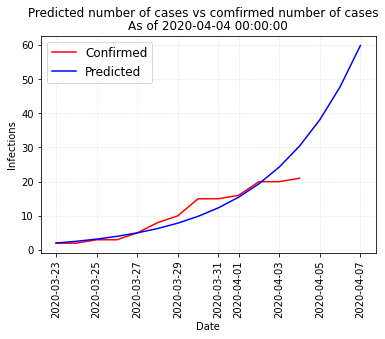

In [21]:
confirmed_x = pd.date_range(start=confirmed_df["Date"][confirmed_df.index[0]], end=confirmed_df["Date"][confirmed_df.index[-1]])
confirmed_y = confirmed_df["Case"].tolist()
confirmed_plot = pd.Series(data=confirmed_y, index=confirmed_x)

nextweek_x = pd.date_range(start=nextweek_df["Date"][nextweek_df.index[0]], end=nextweek_df["Date"][nextweek_df.index[-1]])
nextweek_y = nextweek_df["Predictions"].tolist()
nextweek_plot = pd.Series(data=nextweek_y, index=nextweek_x)

fig, ax = plt.subplots()
ax.plot(confirmed_plot, label="Confirmed", color="red")
ax.plot(nextweek_plot, label="Predicted", color ="blue")
ax.grid(linestyle=':', linewidth='0.5', color='silver')

legend = ax.legend(loc="upper left", fontsize="large")
plt.xlabel("Date")
plt.ylabel("Infections")
plt.suptitle("Predicted number of cases vs comfirmed number of cases")
plt.title("As of "+str(confirmed_df["Date"][confirmed_df.index[-1]]))
plt.xticks(rotation=90)
plt.savefig(real, bbox_inches = "tight")
plt.show()
files.download(real)

# Natural Log Plot

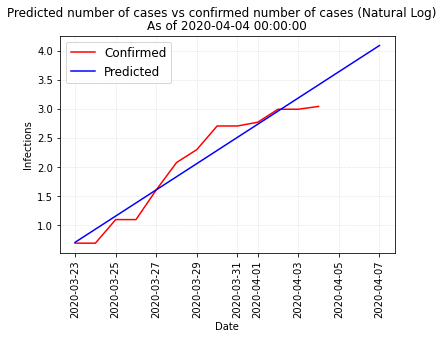

In [22]:
confirmed_logy = confirmed_df["logCase"].tolist()
confirmed_logplot = pd.Series(data=confirmed_logy, index=confirmed_x)

nextweek_logy = nextweek_df["logPredictions"].tolist()
nextweek_logplot = pd.Series(data=nextweek_logy, index=nextweek_x)

fig, ax = plt.subplots()
ax.plot(confirmed_logplot, label="Confirmed", color="red")
ax.plot(nextweek_logplot, label="Predicted", color ="blue")
ax.grid(linestyle=':', linewidth='0.5', color='silver')

legend = ax.legend(loc="upper left", fontsize="large")
plt.xlabel("Date")
plt.ylabel("Infections")
plt.suptitle("Predicted number of cases vs confirmed number of cases (Natural Log)")
plt.title("As of "+str(confirmed_df["Date"][confirmed_df.index[-1]]))
plt.xticks(rotation=90)
plt.savefig(log, bbox_inches = "tight")
plt.show()
files.download(log)

In [20]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? n
Nothing done.
